In [1]:
#!/usr/bin/env python
# -*- coding: utf-8 -*-

# Deep Neural Networks 
## Session 15c

### Using artificial data

## Sequential Modeling Regression
</p><img src='../../images/prasami_color_tutorials_small.png' style = 'width:400px;' alt="By Pramod Sharma : pramod.sharma@prasami.com" align="left"/>

In [2]:
###-----------------
### Import Libraries
###-----------------

import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

import tensorflow as tf

2023-11-28 12:49:02.945824: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2023-11-28 12:49:02.945856: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2023-11-28 12:49:02.946957: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-11-28 12:49:02.952737: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-11-28 12:49:03.604305: W tensorflow/compiler/tf2

In [3]:
###----------------------
### Some basic parameters
###----------------------

inpDir = '../../input' # location where input data is stored
outDir = '../output' # location to store outputs

RANDOM_STATE = 24 # for initialization ----- REMEMBER: to remove at the time of promotion to production
np.random.seed(RANDOM_STATE) # Set Random Seed for reproducible  results
tf.random.set_seed(RANDOM_STATE) # setting for Tensorflow as well

EPOCHS = 100

BATCH_SIZE = 64
# Set parameters for decoration of plots
params = {'legend.fontsize' : 'large',
          'figure.figsize'  : (12,9),
          'axes.labelsize'  : 'x-large',
          'axes.titlesize'  :'x-large',
          'xtick.labelsize' :'large',
          'ytick.labelsize' :'large',
         }

CMAP = plt.cm.coolwarm

plt.rcParams.update(params) # update rcParams

## Basic Hygiene

In [4]:
physical_devices = tf.config.list_physical_devices('GPU') 

if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)

2023-11-28 12:49:04.247623: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 12:49:04.277216: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2023-11-28 12:49:04.277459: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:901] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-

In [5]:
def fn_plot_hist(hist_df):
    
    fig, axes = plt.subplots(1,2 , figsize = (15,6))

    # properties  matplotlib.patch.Patch 
    props = dict(boxstyle='round', facecolor='aqua', alpha=0.4)

    ax = axes[0]

    y1 = hist_df.columns[0]
    y2 = hist_df.columns[2]
    hist_df.plot(y = [y1, y2], ax = ax, colormap=CMAP)

    lossmin = hist_df[y1].min()

    testmin = hist_df[y2].min()

    # little beautification
    txtstr = "Min Loss: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(lossmin,
                                                                            testmin) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.95, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")

    ax.set_ylabel(y1.capitalize())

    ax.grid();

    ax = axes[1]
    
    y1 = hist_df.columns[1]
    y2 = hist_df.columns[3]
    hist_df.plot( y = [y1, y2], ax = ax, colormap=CMAP)
    
    # little beautification
    accmax = hist_df[y1].min()
    testmax = hist_df[y2].min()
    txtstr = "Min MAE: \n Training : {:7.4f}\n Testing   : {:7.4f}".format(accmax,
                                                                                testmax) #text to plot

    # place a text box in upper left in axes coords

    ax.text(0.4, 0.5, txtstr, transform=ax.transAxes, fontsize=14,
            verticalalignment='top', bbox=props)

    ax.set_xlabel("Epochs")
    ax.set_ylabel(y1.capitalize())
    ax.grid();
    plt.tight_layout()

## Create Some Regression data

In [6]:
start = -2.1
end = 2.1

### Training data

delta = 0.001

X_train = np.arange(start, end+ delta,delta)
y_rnd = np.random.rand(X_train.shape[0]) - 0.5
y_true =   2* np.square(X_train) + 2 * np.sin(np.pi*X_train)
y_train = y_true + y_rnd* 2

### Test data
X_test = np.arange(start, end+ delta, delta * 10 )
y_rnd = np.random.rand(X_test.shape[0])- 0.5
y_true_test =   2* np.square(X_test) + 2 * np.sin(np.pi*X_test)
y_test = y_true_test  + y_rnd* 2

In [7]:
X_train.shape

(4201,)

In [9]:
4201/64

65.640625

In [8]:
num_examples = BATCH_SIZE * 65

X_train = X_train[:num_examples]
y_train = y_train[:num_examples]
y_true = y_true[:num_examples]

In [9]:
X_train.shape

(4160,)

In [10]:
X_train.max(), X_test.max()

(2.0589999999995423, 2.0999999999999104)

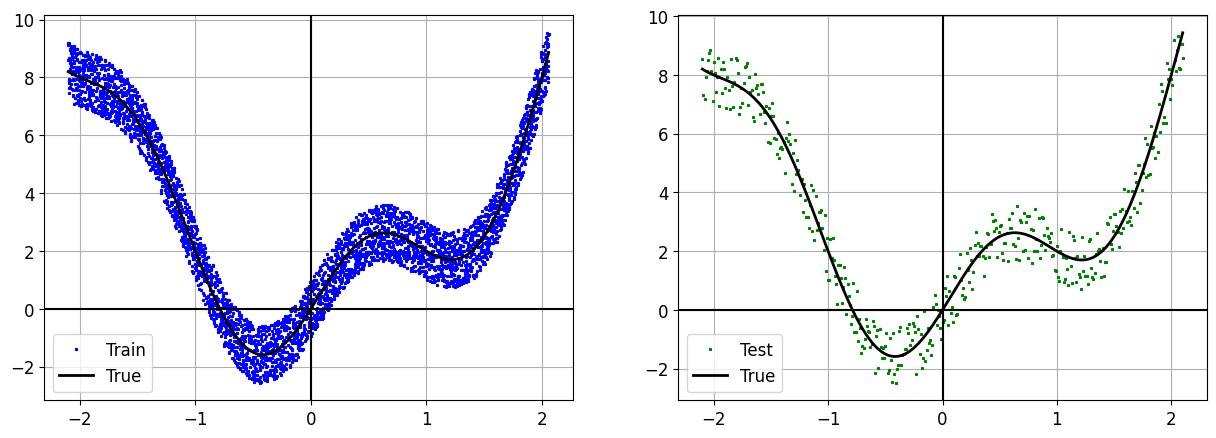

In [11]:
start = -2
end = 2
delta_train = 0.01

fig, axes = plt.subplots(1, 2, figsize =(15,5))

ax = axes[0]
ax.plot(X_train, y_train, 'b*', markersize=2, label = 'Train')
ax.plot(X_train,  y_true, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend()

ax = axes[1]
ax.plot(X_test, y_test, 'g*', markersize=2, label = 'Test')
ax.plot(X_test,  y_true_test, c = 'k', linewidth=2, label = 'True')
ax.axhline(0, c = 'k')
ax.axvline(0, c = 'k')
ax.grid()
ax.legend();

In [13]:
# What shape of Input layer?
num_features = 1

#initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# Define Model

# Define the input layer
input_layer = tf.keras.layers.Input(shape=(1,))  # Assuming input shape is (784,)

# Add a hidden layer with 128 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(128, activation='relu')(input_layer)

# Add another hidden layer with 64 neurons and ReLU activation
hidden_layer = tf.keras.layers.Dense(64, activation='relu')(hidden_layer)

# Add the output layer with 10 neurons (for a classification task) and softmax activation
output_layer = tf.keras.layers.Dense(1)(hidden_layer)

# Create the model by specifying the input and output layers
model = tf.keras.Model(inputs=input_layer, outputs=output_layer)

In [14]:
# Compile the model with a specific optimizer, loss function, and metrics

model.compile(optimizer='adam', loss='mean_squared_error', metrics=['mae'])

In [15]:
# fit the model
history = model.fit(X_train, y_train, 
                    batch_size = BATCH_SIZE,
                    validation_data=[X_test, y_test],
                    epochs=EPOCHS, 
                    verbose=2)

Epoch 1/100


2023-11-28 12:54:39.085425: I external/local_tsl/tsl/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-11-28 12:54:39.337381: I external/local_xla/xla/service/service.cc:168] XLA service 0x7f8a6e3ba2d0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2023-11-28 12:54:39.337404: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3060 Laptop GPU, Compute Capability 8.6
2023-11-28 12:54:39.340987: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:269] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2023-11-28 12:54:39.354064: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:454] Loaded cuDNN version 8902
I0000 00:00:1701156279.403586   92976 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


65/65 - 1s - loss: 9.2707 - mae: 2.3357 - val_loss: 3.9226 - val_mae: 1.6657 - 1s/epoch - 17ms/step
Epoch 2/100
65/65 - 0s - loss: 3.2033 - mae: 1.4686 - val_loss: 2.6950 - val_mae: 1.3603 - 88ms/epoch - 1ms/step
Epoch 3/100
65/65 - 0s - loss: 2.1071 - mae: 1.1856 - val_loss: 1.7628 - val_mae: 1.0817 - 88ms/epoch - 1ms/step
Epoch 4/100
65/65 - 0s - loss: 1.3979 - mae: 0.9515 - val_loss: 1.3590 - val_mae: 0.9137 - 87ms/epoch - 1ms/step
Epoch 5/100
65/65 - 0s - loss: 1.1470 - mae: 0.8374 - val_loss: 1.2473 - val_mae: 0.8672 - 84ms/epoch - 1ms/step
Epoch 6/100
65/65 - 0s - loss: 1.0784 - mae: 0.8082 - val_loss: 1.2126 - val_mae: 0.8545 - 87ms/epoch - 1ms/step
Epoch 7/100
65/65 - 0s - loss: 1.0488 - mae: 0.7982 - val_loss: 1.2041 - val_mae: 0.8406 - 87ms/epoch - 1ms/step
Epoch 8/100
65/65 - 0s - loss: 1.0122 - mae: 0.7822 - val_loss: 1.1290 - val_mae: 0.8240 - 87ms/epoch - 1ms/step
Epoch 9/100
65/65 - 0s - loss: 0.9674 - mae: 0.7666 - val_loss: 1.0791 - val_mae: 0.8173 - 85ms/epoch - 1ms/s

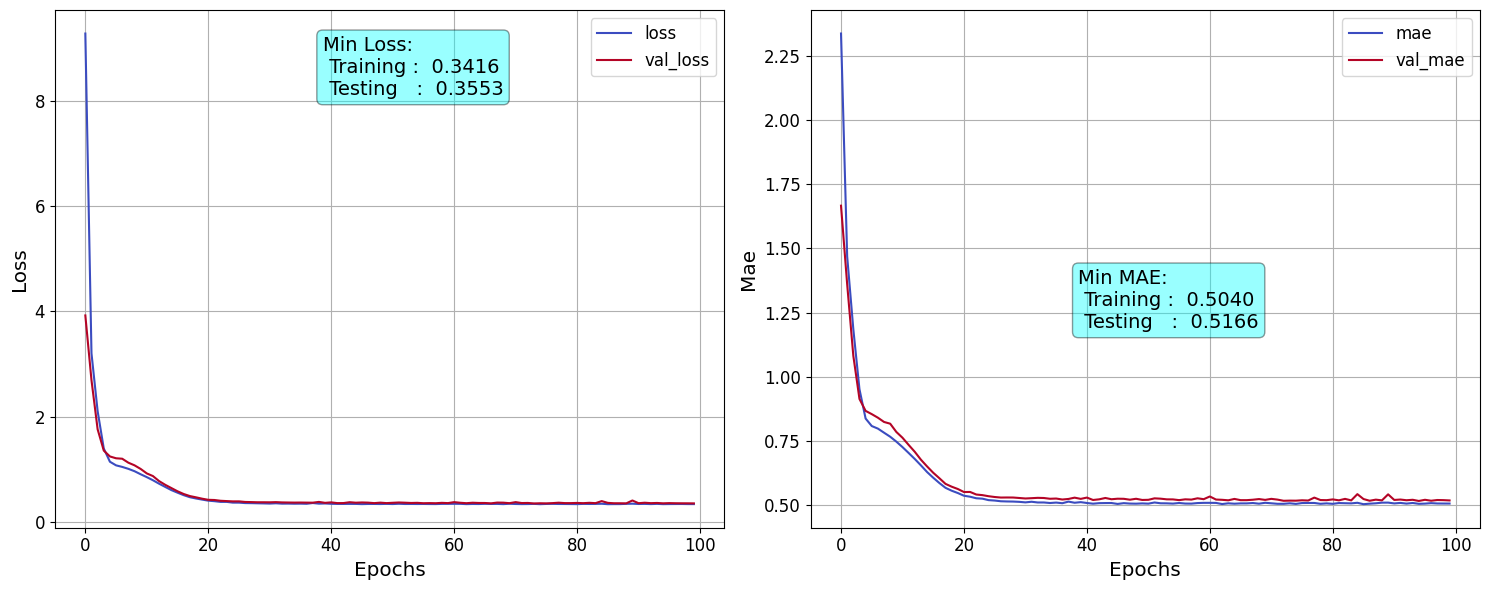

In [16]:
hist_df = pd.DataFrame(history.history)

fn_plot_hist(hist_df)

In [17]:
# evaluate the model
error = model.evaluate(X_test, y_test, verbose=0)

print(f'Loss: {error[0]:.3f}, MAE: {np.sqrt(error[1]):.3f}')

Loss: 0.357, MAE: 0.720


In [18]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:,0], 'test' : y_test} )

results_df['y_true'] = y_true_test

14/14 [==============================] - 0s 829us/step


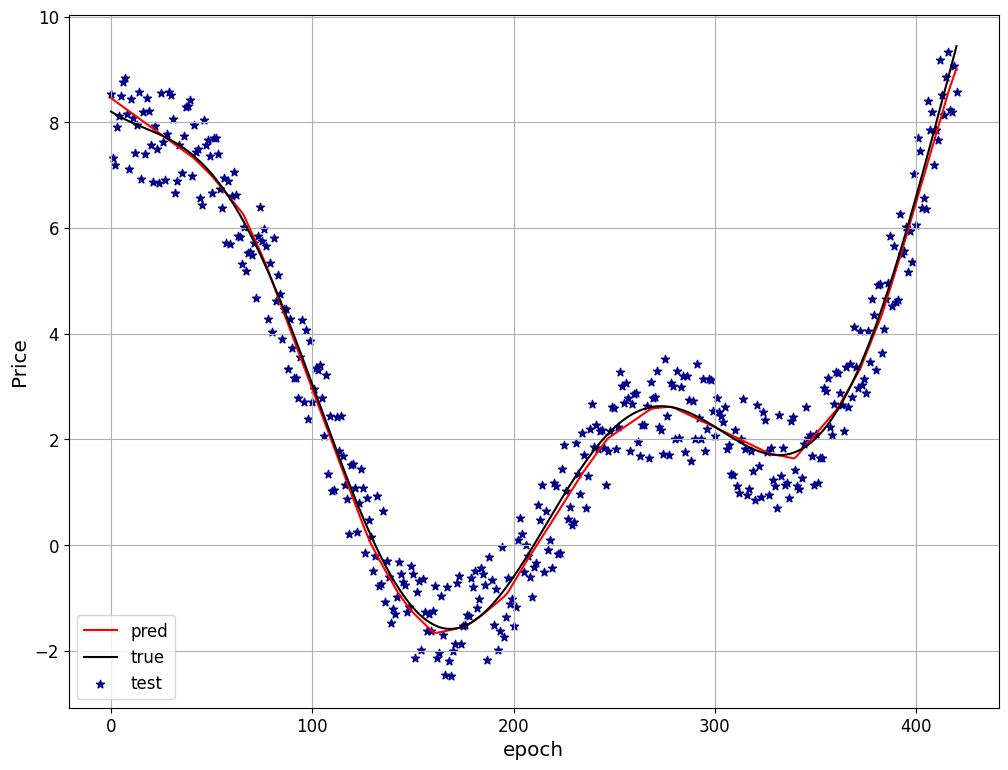

In [19]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()

In [20]:
# What shape of Input layer?
num_features = 1

initializer = tf.keras.initializers.HeNormal(seed = RANDOM_STATE)

# define model
model = tf.keras.Sequential()

model.add( tf.keras.layers.Dense(128, 
                                 activation='swish', 
                                 kernel_initializer=initializer, 
                                 input_shape=(num_features,)))

model.add(tf.keras.layers.Dense(64, 
                                activation='swish', 
                                kernel_initializer=initializer))

model.add(tf.keras.layers.Dense(1))

In [21]:
# compile the model
model.compile(optimizer='adam', loss='mse')

In [22]:
# fit the model
history = model.fit(X_train, y_train, 
          batch_size = BATCH_SIZE,
          validation_data=[X_test, y_test],
          epochs=EPOCHS, 
          verbose=2)

Epoch 1/100
65/65 - 1s - loss: 2.2129 - val_loss: 1.3174 - 652ms/epoch - 10ms/step
Epoch 2/100
65/65 - 0s - loss: 1.0266 - val_loss: 0.9908 - 88ms/epoch - 1ms/step
Epoch 3/100
65/65 - 0s - loss: 0.8438 - val_loss: 0.8249 - 90ms/epoch - 1ms/step
Epoch 4/100
65/65 - 0s - loss: 0.7291 - val_loss: 0.7610 - 87ms/epoch - 1ms/step
Epoch 5/100
65/65 - 0s - loss: 0.6833 - val_loss: 0.6784 - 89ms/epoch - 1ms/step
Epoch 6/100
65/65 - 0s - loss: 0.6140 - val_loss: 0.6563 - 89ms/epoch - 1ms/step
Epoch 7/100
65/65 - 0s - loss: 0.6033 - val_loss: 0.6411 - 87ms/epoch - 1ms/step
Epoch 8/100
65/65 - 0s - loss: 0.5870 - val_loss: 0.5755 - 92ms/epoch - 1ms/step
Epoch 9/100
65/65 - 0s - loss: 0.5470 - val_loss: 0.5676 - 89ms/epoch - 1ms/step
Epoch 10/100
65/65 - 0s - loss: 0.5261 - val_loss: 0.5501 - 119ms/epoch - 2ms/step
Epoch 11/100
65/65 - 0s - loss: 0.4943 - val_loss: 0.5209 - 88ms/epoch - 1ms/step
Epoch 12/100
65/65 - 0s - loss: 0.4905 - val_loss: 0.5110 - 86ms/epoch - 1ms/step
Epoch 13/100
65/65 - 0

In [23]:
y_pred = model.predict(X_test)

results_df = pd.DataFrame({'pred' : y_pred[:, 0], 'test' : y_test} )

results_df['y_true'] = y_true_test

14/14 [==============================] - 0s 765us/step


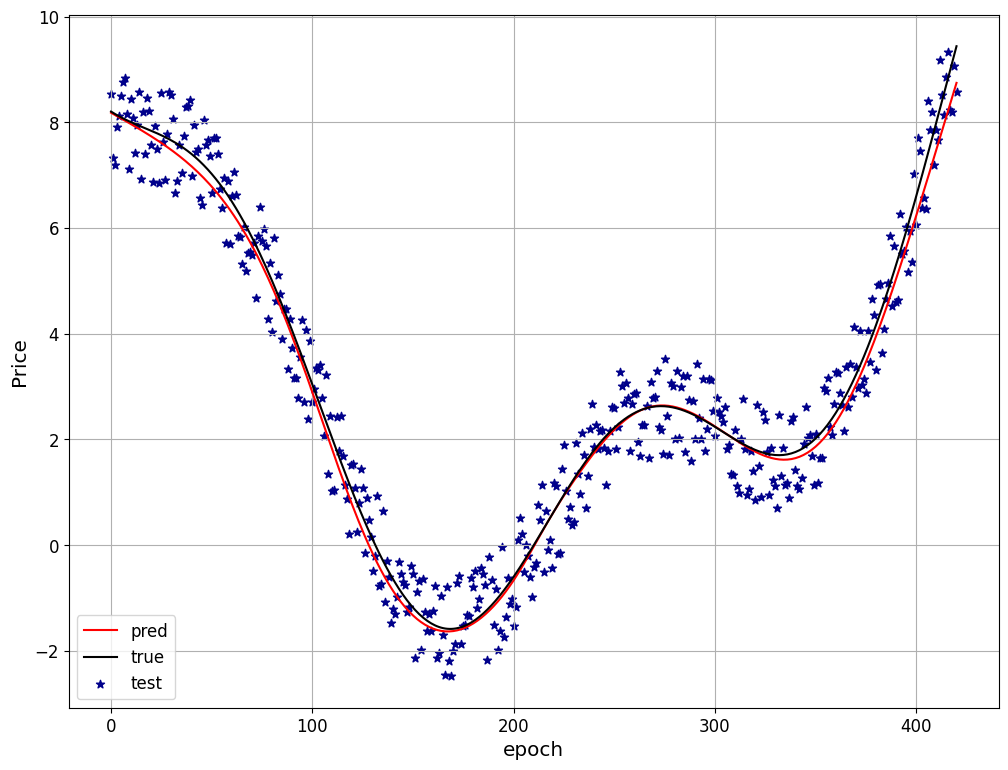

In [24]:
ax = results_df.pred.plot(c = 'r', label = 'pred');
results_df.y_true.plot(c = 'k', ax = ax, label = 'true')

plt.scatter(results_df.index, results_df.test, c='DarkBlue', marker ='*', label = 'test');
ax.set_xlabel("epoch")
ax.set_ylabel("Price")
ax.grid()
plt.legend()
plt.show()